In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import regularizers


pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/conflict-clusters.csv')

In [3]:
df.head()

,event_date,year,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,fatalities,timestamp,MA/CU,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km,db_50_clusters
0,2017-01-01,2017,Explosions/Remote violence,Remote explosive/landmine/IED,Unidentified Armed Group (Egypt),unknown,3,unknown,unknown,0,30,Northern Africa,Egypt,Cairo,Al Maadi,unknown,Cairo-Al Maadi,29.9667,31.2500,1,0,1578503454,MA,564,56,1,0.0,18.6331,11.74,-0.54,-0.62,-0.55,-0.86,-1.25,-1.42,32,6,5,4,6,5,106.76,35,33,67,51,71.66,89.8,8.1,8.2,4.9,9.8,7.3,30.66,48.01,42.71,97.0,0
1,2017-01-01,2017,Battles,Armed clash,Military Forces of Iraq (2014-2018) Popular Mo...,unknown,1,Islamic State (Iraq),unknown,2,12,Middle East,Iraq,Anbar,Anah,unknown,Aradi as Sakrah,34.1915,42.0313,3,6,1567462133,MA,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0,1
2,2017-01-01,2017,Explosions/Remote violence,Air/drone strike,Military Forces of Iraq (2014-2018),unknown,1,Islamic State (Iraq),unknown,2,12,Middle East,Iraq,Ninewa,Mosul,unknown,Mosul,36.3350,43.1189,1,20,1572403769,MA,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0,1
3,2017-01-01,2017,Explosions/Remote violence,Remote explosive/landmine/IED,Islamic State (Iraq),unknown,2,Civilians (Iraq),unknown,7,27,Middle East,Iraq,Najaf,Najaf,unknown,Najaf,32.0259,44.3462,2,6,1572403770,MA,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0,1
4,2017-01-01,2017,Battles,Armed clash,Islamic State (Iraq),unknown,2,Police Forces of Iraq (2014-2018),unknown,1,12,Middle East,Iraq,Najaf,Manathera,unknown,Al Mishkhab,31.8044,44.4893,1,0,1572403770,MA,46,56,1,0.0,1181.5465,13.02,-1.64,-1.26,-1.37,-1.20,-1.05,-2.31,18,5,6,6,7,7,88.98,37,19,61,68,70.29,105.4,10.0,9.5,8.2,8.7,9.9,9.77,42.49,70.28,87.0,1


In [4]:
data = df.loc[df['country'] == 'Syria', :]

In [5]:
data.head()

,event_date,year,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,fatalities,timestamp,MA/CU,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km,db_50_clusters
14,2017-01-01,2017,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Syria (2000-),Militia (Pro-Government); Shiite Muslim Militi...,1,Civilians (Syria),unknown,7,17,Middle East,Syria,Rural Damascus,Az-Zabdani,Ein Elfijeh,Deir Qanun,33.6039,36.1361,1,2,1571164394,MA,38,56,1,1.0,213.976,8.36,-2.09,-1.77,-1.56,-1.83,-1.97,-2.62,14,7,7,7,7,7,90.0,37,30,66,56,70.97,110.6,9.8,9.9,9.2,9.8,9.8,4.83,41.52,53.5,93.0,1
15,2017-01-01,2017,Battles,Armed clash,Military Forces of Syria (2000-),unknown,1,FaR: Al Rahman Corps,unknown,2,12,Middle East,Syria,Rural Damascus,Duma,Nashabiyeh,Hazrama,33.5165,36.4897,1,1,1571164394,MA,38,56,1,1.0,213.976,8.36,-2.09,-1.77,-1.56,-1.83,-1.97,-2.62,14,7,7,7,7,7,90.0,37,30,66,56,70.97,110.6,9.8,9.9,9.2,9.8,9.8,4.83,41.52,53.5,93.0,1
16,2017-01-01,2017,Battles,Armed clash,Military Forces of Syria (2000-),unknown,1,Unidentified Armed Group (Syria),unknown,3,13,Middle East,Syria,Rural Damascus,Az-Zabdani,Ein Elfijeh,Hseiniyeh,33.6094,36.1234,2,0,1567462248,MA,38,56,1,1.0,213.976,8.36,-2.09,-1.77,-1.56,-1.83,-1.97,-2.62,14,7,7,7,7,7,90.0,37,30,66,56,70.97,110.6,9.8,9.9,9.2,9.8,9.8,4.83,41.52,53.5,93.0,1
17,2017-01-01,2017,Explosions/Remote violence,Air/drone strike,Military Forces of Syria (2000-) Syrian Arab A...,unknown,1,unknown,unknown,0,10,Middle East,Syria,Homs,Tadmor,Sokhneh,Sokhneh,34.8832,38.8700,2,0,1567462271,MA,38,56,1,1.0,213.976,8.36,-2.09,-1.77,-1.56,-1.83,-1.97,-2.62,14,7,7,7,7,7,90.0,37,30,66,56,70.97,110.6,9.8,9.9,9.2,9.8,9.8,4.83,41.52,53.5,93.0,1
18,2017-01-01,2017,Explosions/Remote violence,Shelling/artillery/missile attack,Military Forces of Syria (2000-),unknown,1,unknown,unknown,0,10,Middle East,Syria,Hama,As-Salamiyeh,As-Salamiyeh,Taloul al-Humr,34.9568,36.9580,1,0,1567462271,MA,38,56,1,1.0,213.976,8.36,-2.09,-1.77,-1.56,-1.83,-1.97,-2.62,14,7,7,7,7,7,90.0,37,30,66,56,70.97,110.6,9.8,9.9,9.2,9.8,9.8,4.83,41.52,53.5,93.0,1


In [6]:
data.shape

(65966, 58)

In [7]:
data.drop(columns=['year', 
                   'sub_event_type',
                   'actor1',
                   'assoc_actor_1',
                   'inter1',
                   'actor2',
                   'assoc_actor_2',
                   'inter2',
                   'interaction',
                   'region',
                   'admin2',
                   'admin3',
                   'location',
                   'timestamp',
                   'country',
                   'MA/CU'], inplace=True)

In [8]:
df = (pd.to_datetime(data['event_date']).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count'))

In [9]:
df.head()

,date,count
0,2017-09-25,173
1,2017-01-10,160
2,2017-09-26,151
3,2017-04-26,150
4,2017-04-22,146


In [10]:
data['event_date'] = pd.to_datetime(data['event_date'])

In [11]:
data = pd.merge(data, df, left_on='event_date', right_on='date', how='outer')

In [12]:
data.head()

,event_date,event_type,admin1,latitude,longitude,geo_precision,fatalities,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km,db_50_clusters,date,count
0,2017-01-01,Explosions/Remote violence,Rural Damascus,33.6039,36.1361,1,2,38,56,1,1.0,213.976,8.36,-2.09,-1.77,-1.56,-1.83,-1.97,-2.62,14,7,7,7,7,7,90.0,37,30,66,56,70.97,110.6,9.8,9.9,9.2,9.8,9.8,4.83,41.52,53.5,93.0,1,2017-01-01,72
1,2017-01-01,Battles,Rural Damascus,33.5165,36.4897,1,1,38,56,1,1.0,213.976,8.36,-2.09,-1.77,-1.56,-1.83,-1.97,-2.62,14,7,7,7,7,7,90.0,37,30,66,56,70.97,110.6,9.8,9.9,9.2,9.8,9.8,4.83,41.52,53.5,93.0,1,2017-01-01,72
2,2017-01-01,Battles,Rural Damascus,33.6094,36.1234,2,0,38,56,1,1.0,213.976,8.36,-2.09,-1.77,-1.56,-1.83,-1.97,-2.62,14,7,7,7,7,7,90.0,37,30,66,56,70.97,110.6,9.8,9.9,9.2,9.8,9.8,4.83,41.52,53.5,93.0,1,2017-01-01,72
3,2017-01-01,Explosions/Remote violence,Homs,34.8832,38.8700,2,0,38,56,1,1.0,213.976,8.36,-2.09,-1.77,-1.56,-1.83,-1.97,-2.62,14,7,7,7,7,7,90.0,37,30,66,56,70.97,110.6,9.8,9.9,9.2,9.8,9.8,4.83,41.52,53.5,93.0,1,2017-01-01,72
4,2017-01-01,Explosions/Remote violence,Hama,34.9568,36.9580,1,0,38,56,1,1.0,213.976,8.36,-2.09,-1.77,-1.56,-1.83,-1.97,-2.62,14,7,7,7,7,7,90.0,37,30,66,56,70.97,110.6,9.8,9.9,9.2,9.8,9.8,4.83,41.52,53.5,93.0,1,2017-01-01,72


In [13]:
data.set_index('event_date', inplace=True)

In [14]:
data.drop(columns='date', inplace=True)

In [15]:
pd.get_dummies(data=data, 
               columns=['event_type',
                        'admin1'])

,latitude,longitude,geo_precision,fatalities,users,frac,month,missing_data,Exchange rate USD,Unemployment rate,Rule of law index (-2.5 weak; 2.5 strong),Government effectiveness index (-2.5 weak; 2.5 strong),Control of corruption (-2.5 weak; 2.5 strong),Regulatory quality index (-2.5 weak; 2.5 strong),Voice and accountability index (-2.5 weak; 2.5 strong),Political stability index (-2.5 weak; 2.5 strong),Corruption Perceptions Index 100 = no corruption,Political rights index 7 (weak) - 1 (strong),Civil liberties index 7 (weak) - 1 (strong),Short-term political risk (1=low 7=high),Medium/long-term political risk (1=low 7=high),Political violence risk (1=low 7=high),Mobile phone subscribers per 100 people,Property rights index (0-100),Freedom from corruption index (0-100),Business freedom index (0-100),Labor freedom index (0-100),Life expectancy in years,Fragile state index 0 (low) - 120 (high),Security threats index 0 (low) - 10 (high),State legitimacy index 0 (high) - 10 (low),Public services index 0 (high) - 10 (low),Human rights and rule of law index 0 (high) - 10 (low),Refugees and displaced persons index 0 (low) - 10 (high),Labor force million people,Labor force participation rate,Percent urban population,Population density people per square km,db_50_clusters,count,event_type_Battles,event_type_Explosions/Remote violence,event_type_Protests,event_type_Riots,event_type_Violence against civilians,admin1_Al-Hasakeh,admin1_Aleppo,admin1_Ar-Raqqa,admin1_As-Sweida,admin1_Damascus,admin1_Dar'a,admin1_Deir-ez-Zor,admin1_Hama,admin1_Homs,admin1_Idleb,admin1_Lattakia,admin1_Quneitra,admin1_Rural Damascus,admin1_Tartous
event_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,33.6039,36.1361,1,2,38,56,1,1.0,213.9760,8.36,-2.09,-1.77,-1.560,-1.830,-1.970,-2.62,14,7,7,7,7,7,90.00,37,30,66,56,70.97,110.6,9.8,9.9,9.2,9.8,9.8,4.83,41.52,53.50,93.0,1,72,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-01-01,33.5165,36.4897,1,1,38,56,1,1.0,213.9760,8.36,-2.09,-1.77,-1.560,-1.830,-1.970,-2.62,14,7,7,7,7,7,90.00,37,30,66,56,70.97,110.6,9.8,9.9,9.2,9.8,9.8,4.83,41.52,53.50,93.0,1,72,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-01-01,33.6094,36.1234,2,0,38,56,1,1.0,213.9760,8.36,-2.09,-1.77,-1.560,-1.830,-1.970,-2.62,14,7,7,7,7,7,90.00,37,30,66,56,70.97,110.6,9.8,9.9,9.2,9.8,9.8,4.83,41.52,53.50,93.0,1,72,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-01-01,34.8832,38.8700,2,0,38,56,1,1.0,213.9760,8.36,-2.09,-1.77,-1.560,-1.830,-1.970,-2.62,14,7,7,7,7,7,90.00,37,30,66,56,70.97,110.6,9.8,9.9,9.2,9.8,9.8,4.83,41.52,53.50,93.0,1,72,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2017-01-01,34.9568,36.9580,1,0,38,56,1,1.0,213.9760,8.36,-2.09,-1.77,-1.560,-1.830,-1.970,-2.62,14,7,7,7,7,7,90.00,37,30,66,56,70.97,110.6,9.8,9.9,9.2,9.8,9.8,4.83,41.52,53.50,93.0,1,72,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31,36.5111,36.8655,1,0,17,55,12,1.0,514.9994,8.37,-2.07,-1.72,-1.595,-1.815,-1.965,-2.68,13,7,7,7,7,7,95.55,37,20,50,58,71.38,111.5,9.8,9.9,9.4,10.0,10.0,4.80,40.76,53.83,92.5,1,33,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2019-12-31,36.6978,38.9548,1,0,17,55,12,1.0,514.9994,8.37,-2.07,-1.72,-1.595,-1.815,-1.965,-2.68,13,7,7,7,7,7,95.55,37,20,50,58,71.38,111.5,9.8,9.9,9.4,10.0,10.0,4.80,40.76,53.83,92.5,1,33,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2019-12-31,35.6159,36.7188,1,0,17,55,12,1.0,514.9994,8.37,-2.07,-1.72,-1.595,-1.815,-1.965,-2.68,13,7,7,7,7,7,95.55,37,20,50,58,71.38,111.5,9.8,9.9,9.4,10.0,10.0,4.80,40.76,53.83,92.5,1,33,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [25]:
data.drop(columns=['event_type', 'admin1'], inplace=True)

In [26]:
y = data['count']
X = data.drop(columns=['count'])


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [28]:
minmax = MinMaxScaler()

In [29]:
X_train = minmax.fit_transform(X_train)
X_test = minmax.fit_transform(X_test)

In [30]:
X_train.shape

(49474, 39)

In [39]:
train = TimeseriesGenerator(X_train, y_train, length=3, batch_size=64)
test = TimeseriesGenerator(X_test, y_test, length=3, batch_size=64)

In [40]:
batch_x, batch_y = train[0]

In [41]:
batch_x.shape

(64, 3, 39)

In [44]:
# The LSTM design
model = Sequential()
# First LSTM layer with Dropout 
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(3, 39)))
model.add(Dropout(0.5))
# Second LSTM layer
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(Dropout(0.5))
# Third LSTM layer
model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(Dropout(0.5))
# The output layer

model.add(Flatten())
model.add(Dense(1))

# Compiling the RNN
model.compile(optimizer='Adam', loss='mean_absolute_percentage_error')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 3, 64)             26624     
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 192)              

In [45]:
# Fitting to the training set
hist = model.fit_generator(train, validation_data=(test), epochs=20)

Epoch 1/20
773/773 [==============================] - 6s 8ms/step - loss: 39.2638 - val_loss: 75.7884
Epoch 2/20
773/773 [==============================] - 5s 7ms/step - loss: 29.6730 - val_loss: 41.3422
Epoch 3/20
773/773 [==============================] - 6s 7ms/step - loss: 26.3993 - val_loss: 24.6090
Epoch 4/20
773/773 [==============================] - 6s 7ms/step - loss: 25.7116 - val_loss: 13.4060
Epoch 5/20
773/773 [==============================] - 6s 7ms/step - loss: 24.8596 - val_loss: 19.0765
Epoch 6/20
773/773 [==============================] - 6s 7ms/step - loss: 24.4708 - val_loss: 4.9605
Epoch 7/20
773/773 [==============================] - 6s 7ms/step - loss: 24.0653 - val_loss: 6.9458
Epoch 8/20
773/773 [==============================] - 6s 7ms/step - loss: 23.9149 - val_loss: 12.9414
Epoch 9/20
773/773 [==============================] - 6s 7ms/step - loss: 23.7700 - val_loss: 8.6328
Epoch 10/20
773/773 [==============================] - 6s 7ms/step - loss: 24.0414 - 

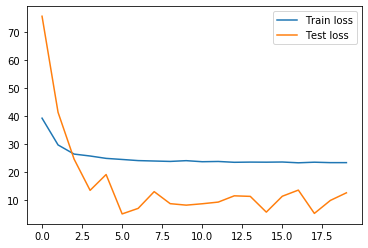

In [46]:

plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.legend();

In [37]:
preds = model.predict(test)

In [38]:
preds

array([[36.381706],
       [35.81288 ],
       [38.41641 ],
       ...,
       [33.302006],
       [33.088448],
       [33.088318]], dtype=float32)